# Showcase for ptdalgorithms

Python header:

In [1]:
%load_ext rpy2.ipython

from IPython.display import Image
from graphviz import Digraph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

def plot_graph(states, ipv, sim, constrained=True, size='10'):

    constrained = constrained and 'true' or 'false'
    states = np.array(states)
    
    # add the missing row and col to SIM
    rates = np.r_[np.c_[sim, -sim.sum(axis=1)], np.zeros((1, len(sim)+1))]

    dot = Digraph()
    dot.node('S', 'S')
    for i in range(1, len(states)):
        dot.node(str(i), str(states[i]))
    for i in range(len(ipv)):
        if ipv[i]:
            dot.edge('S', str(i+1), constraint=constrained, label=str(ipv[i]))
    for i in range(1, len(states)):
        for j in range(1, len(states)):
            if i != j and rates[i-1, j-1] > 0:
                dot.edge(str(i), str(j), constraint=constrained, label=str(rates[i-1, j-1]))
    dot.graph_attr['size'] = size                
    return dot

R header:

In [7]:
%%R
library(devtools)
# remove.packages("ptdalgorithms")

devtools::install_github("TobiasRoikjer/PtDAlgorithms")

library(ptdalgorithms)

R[write to console]: Fejl: Failed to install 'unknown package' from GitHub:
  Failed to connect to api.github.com port 443 after 1001 ms: Opkobling nægtet




Fejl: Failed to install 'unknown package' from GitHub:
  Failed to connect to api.github.com port 443 after 1001 ms: Opkobling nægtet


RInterpreterError: Failed to parse and evaluate line 'library(devtools)\n# remove.packages("ptdalgorithms")\n\ndevtools::install_github("TobiasRoikjer/PtDAlgorithms")\n\nlibrary(ptdalgorithms)\n'.
R error message: "Fejl: Failed to install 'unknown package' from GitHub:\n  Failed to connect to api.github.com port 443 after 1001 ms: Opkobling nægtet"

## Standard coalescent

In [ ]:
%%R -o states -o ipv -o sim
n <- 4
  
state_vector_length <- n
graph <- create_graph(state_vector_length)
starting_vertex <- vertex_at(graph, 1)
initial_state <- rep(0, n)
initial_state[1] <- n

add_edge(
  starting_vertex,
  create_vertex(graph, initial_state),
  1
)
index <- 2

while (index <= vertices_length(graph)) {
  vertex <- vertex_at(graph, index)
  
  # loop over all classes of lineages
  for (i in 1:n) {
    for (j in i:n) {
      state <- vertex$state
      
      # if same class, there need to be at least two to coalesce
      if (i == j) {
        if (state[i] < 2) {
          next;
        }
        # coal rate
        rate <- state[i] * (state[i] - 1) / 2
      } else {
        # else at least one in each class to coalesce
        if (state[i] < 1 || state[j] < 1) {
          next;
        }
        # number of combinations
        rate <- state[i] * state[j]
      }
      
      # copy state
      child_state <- state
      # update child state
      child_state[i] <- child_state[i] - 1
      child_state[j] <- child_state[j] - 1
      child_state[i+j] <- child_state[i+j] + 1
      
      add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          rate
        )
    }
  }
      
  index <- index + 1
}

states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
ipv <- graph_as_matrix(graph)$IPV
sim <- graph_as_matrix(graph)$SIM

vertices_length(graph)

In [ ]:
plot_graph(states, ipv, sim)

### As matrices

In [ ]:
%%R -o states -o sim
matrices <- graph_as_matrix(graph)
states <- matrices$states
sim <- matrices$SIM
matrices

Invert subintensity matrix to get Green matrix:

In [ ]:
%%R
U <- -solve(matrices$SIM)
U

Compute expectation from matrices:

In [ ]:
%%R
matrices$IPV %*% U %*% rep(1, length(matrices$IPV))

### Compute moments

In [ ]:
%%R
expectation(graph)

In [ ]:
%%R
expected_waiting_time(graph)

In [ ]:
%%R
variance(graph)

In [ ]:
%%R
2 * expected_waiting_time(graph, expected_waiting_time(graph)) - expected_waiting_time(graph) * expected_waiting_time(graph)

In [ ]:
%%R
moments(graph, 4)

### Multivariate using rewards

In [ ]:
%%R
state_matrix <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
state_matrix

Rows happens to be our reward vectors. E.g. singleton rewards:

In [ ]:
%%R
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
singletons <- rewards[1,]
doubletons <- rewards[2,]
tripletons <- rewards[3,]
singletons

Expected tripleton branch length:

In [ ]:
%%R
expectation(graph, tripletons)

SFS:

In [ ]:
%%R -o sfs
sfs <- sapply(1:(dim(rewards)[1]-1), function(i) expectation(graph, rewards[i,]))
sfs

In [ ]:
sns.barplot(x=list(range(1, len(sfs)+1)), y=sfs)
sns.despine()

### Cross-moments

In [ ]:
%%R
covariance(graph, singletons, doubletons)

In [ ]:
%%R
covariance(graph, singletons, tripletons)

# Simple model in Keynote presentation

In [ ]:
%%R -o states -o ipv -o sim

graph <- create_graph(1)

A <- create_vertex(graph, c(1))
B <- create_vertex(graph, c(2))
C <- create_vertex(graph, c(3))
D <- create_vertex(graph, c(4))

add_edge(starting_vertex(graph), A, 1)
add_edge(A, B, 0.12)
add_edge(A, D, 0.08)
add_edge(B, C, 0.25)
add_edge(B, D, 0.25)
add_edge(C, A, 0.2)

states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state, simplify = FALSE))
ipv <- graph_as_matrix(graph)$IPV
sim <- graph_as_matrix(graph)$SIM

vertices_length(graph)

In [ ]:
plot_graph(states, ipv, sim)

States:

In [ ]:
%%R
expected_waiting_time(graph)

Convert graph to matrix:

In [ ]:
%%R
graph_as_matrix(graph)

Invert subintensity matrix to get Green matrix:

In [ ]:
%%R
U <- -solve(graph_as_matrix(graph)$SIM)
U

Sum first row of Green matrix to get expectation:

In [ ]:
%%R
rowSums(U)

## Super simple model in Keynote presentation

Simplest possible model as example of how higher order moments are computed.

In [ ]:
%%R -o states -o ipv -o sim

graph <- create_graph(1)

A <- create_vertex(graph, c(1))
B <- create_vertex(graph, c(2))
C <- create_vertex(graph, c(3))
D <- create_vertex(graph, c(4))

add_edge(starting_vertex(graph), A, 1)
add_edge(A, B, 1)
add_edge(B, C, 1)
add_edge(C, D, 1)

states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state, simplify = FALSE))
ipv <- graph_as_matrix(graph)$IPV
sim <- graph_as_matrix(graph)$SIM

In [ ]:
plot_graph(states, ipv, sim, constrained=False)

In [ ]:
%%R
expected_waiting_time(graph)

In [ ]:
%%R
expected_waiting_time(graph, expected_waiting_time(graph))

In [ ]:
%%R
moments(graph, 3)

In [6]:
%%R
2 * expected_waiting_time(graph, expected_waiting_time(graph)) - expected_waiting_time(graph) * expected_waiting_time(graph)

R[write to console]: Fejl i expected_waiting_time(graph, expected_waiting_time(graph)) : 
  could not find function "expected_waiting_time"




Fejl i expected_waiting_time(graph, expected_waiting_time(graph)) : 
  could not find function "expected_waiting_time"


RInterpreterError: Failed to parse and evaluate line '2 * expected_waiting_time(graph, expected_waiting_time(graph)) - expected_waiting_time(graph) * expected_waiting_time(graph)\n'.
R error message: 'Fejl i expected_waiting_time(graph, expected_waiting_time(graph)) : \n  could not find function "expected_waiting_time"'

In [4]:
%%R
variance(graph)

R[write to console]: Fejl i variance(graph) : could not find function "variance"




Fejl i variance(graph) : could not find function "variance"


RInterpreterError: Failed to parse and evaluate line 'variance(graph)\n'.
R error message: 'Fejl i variance(graph) : could not find function "variance"'

## Rabbit model

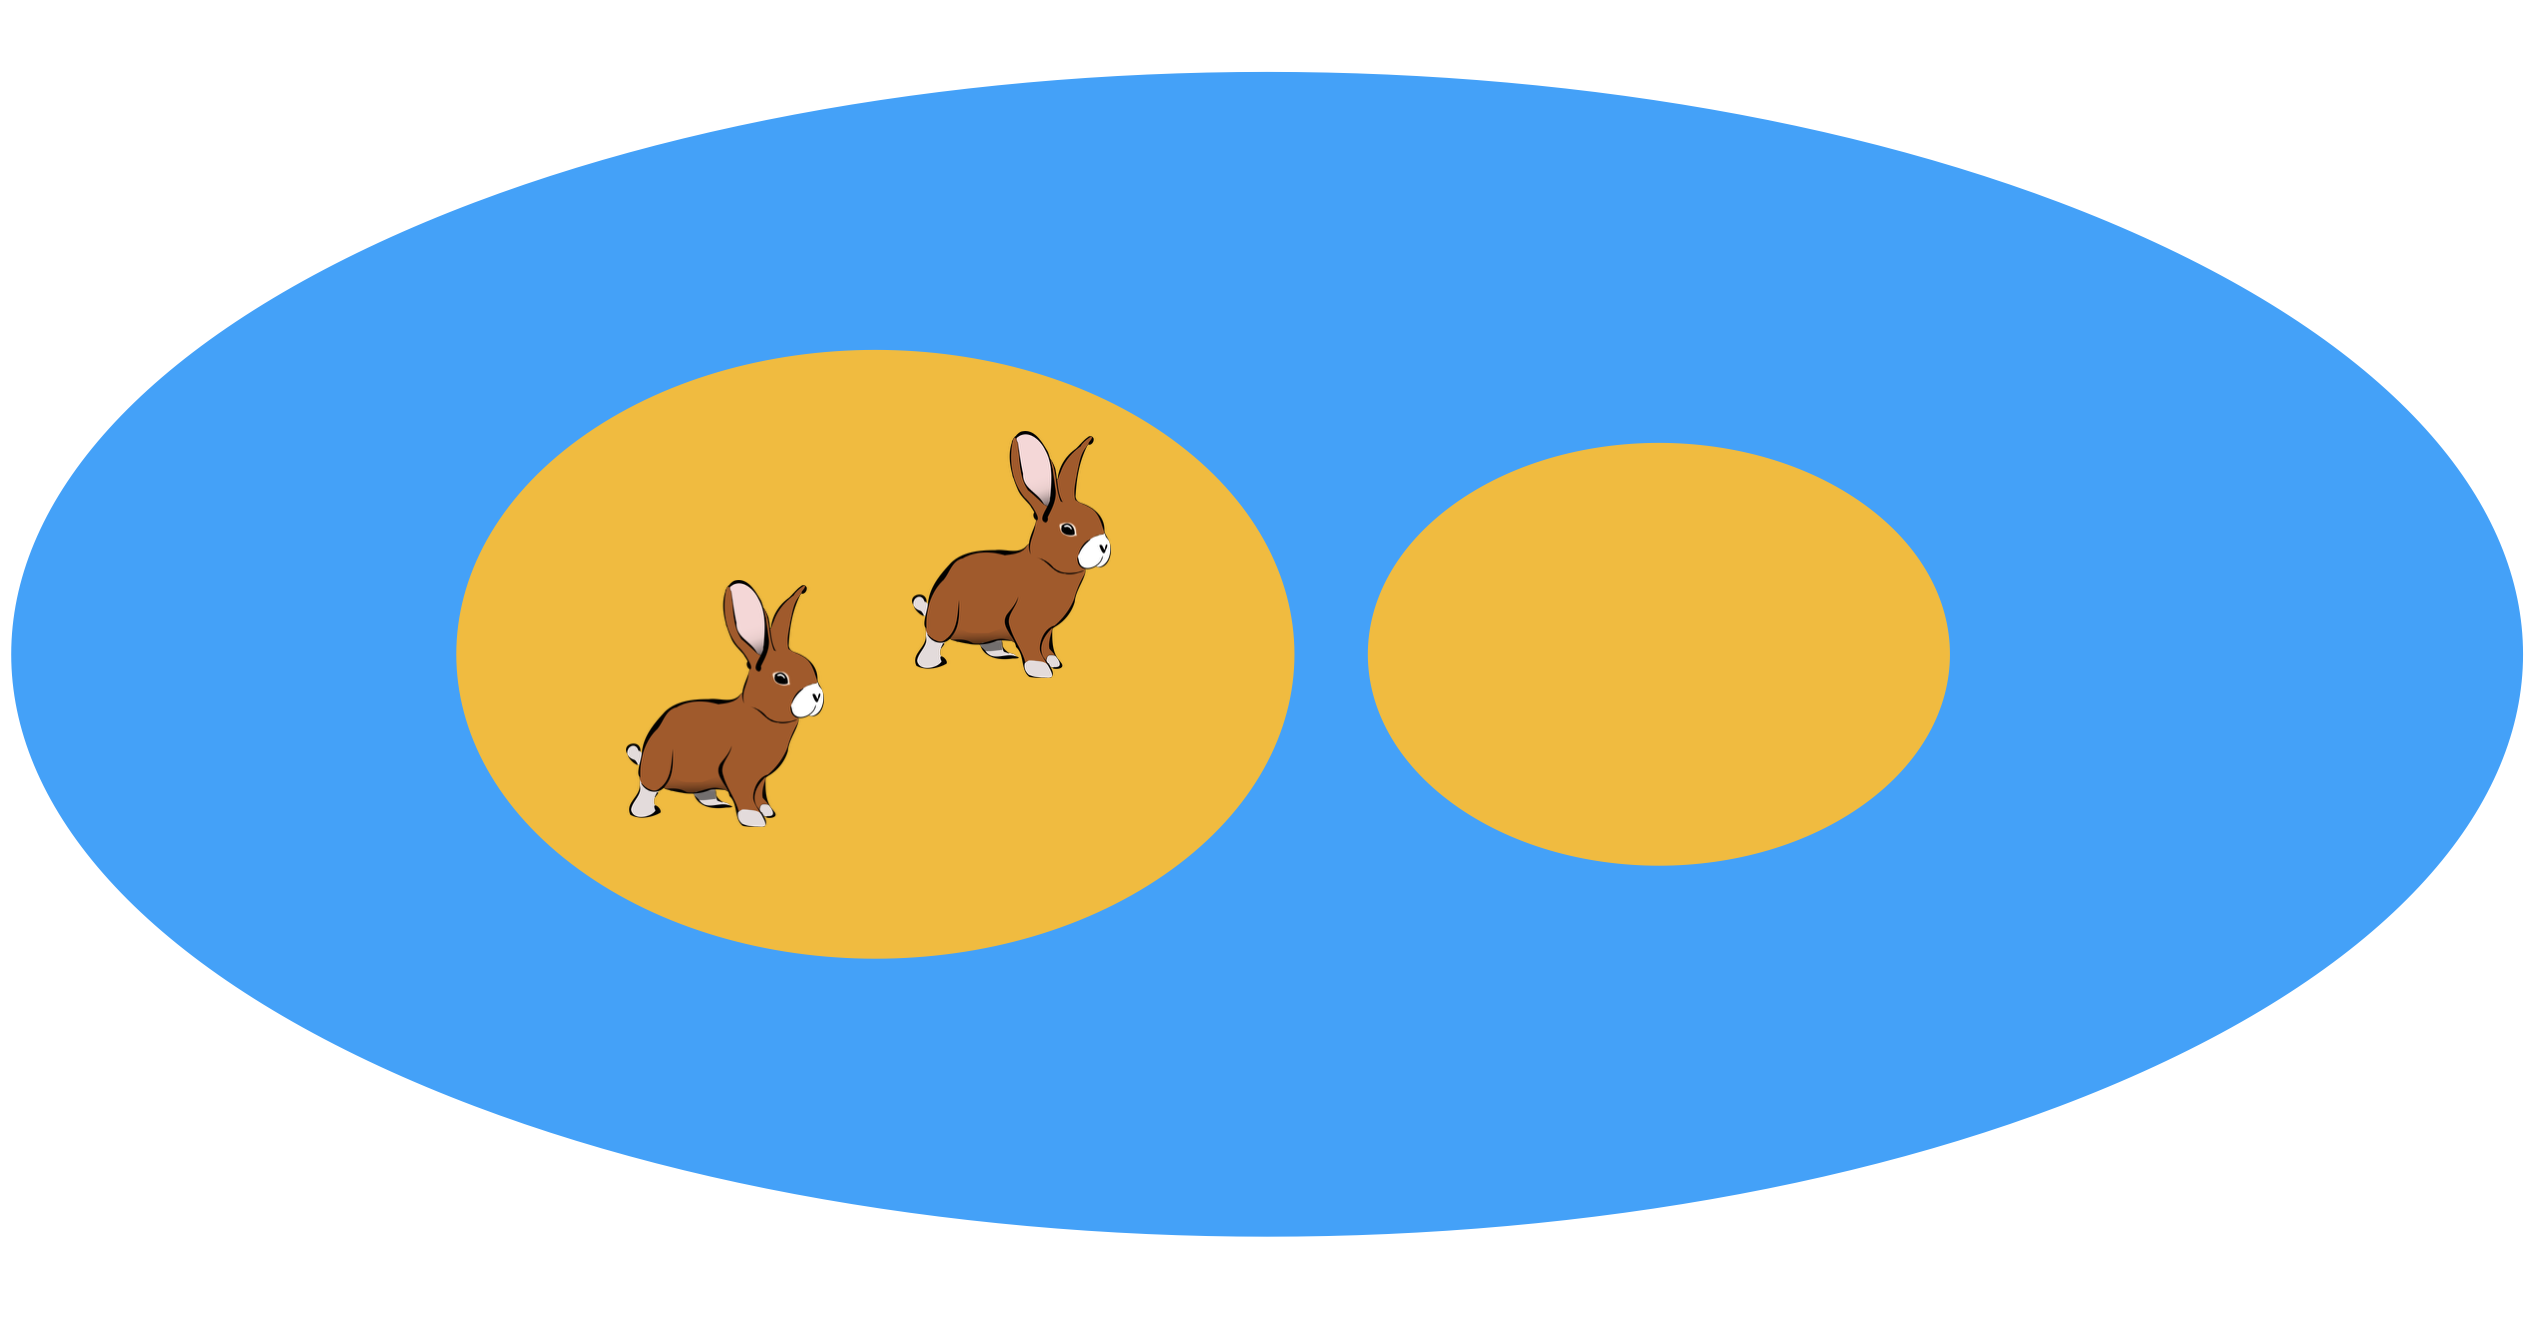

In [9]:
Image("../images/rabbitislands.png", width=600)

In [251]:
%%R -o states -o ipv -o sim
L <- 2
  
tim <- proc.time()
state_vector_length <- 2
graph <- create_graph(state_vector_length)
starting_vertex <- vertex_at(graph, 1)
initial_state <- c(L, 0)

add_edge(
  starting_vertex,
  create_vertex(graph, initial_state),
  1
)
index <- 2

while (index <= vertices_length(graph)) {
  vertex <- vertex_at(graph, index)
  state <- vertex$state
  
  if (state[1] > 0) {
    # Rabbit jump left to right
    child_state <- c(state[1] - 1, state[2] + 1)
    add_edge(
      vertex,
      find_or_create_vertex(graph, child_state),
      1
    )
    
    # Island flooding
    child_state <- c(0, state[2])
    add_edge(
      vertex,
      find_or_create_vertex(graph, child_state),
      2
    )
  }
  
  if (state[2] > 0) {
    # Rabbit jump right to left
    child_state <- c(state[1] + 1, state[2] - 1)
    add_edge(
      vertex,
      find_or_create_vertex(graph, child_state),
      1
    )
    
    # Island flooding
    child_state <- c(state[1], 0)
    add_edge(
      vertex,
      find_or_create_vertex(graph, child_state),
      4
    )
  }
  
  index <- index + 1
}

states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
ipv <- graph_as_matrix(graph)$IPV
sim <- graph_as_matrix(graph)$SIM

vertices_length(graph)

[1] 7


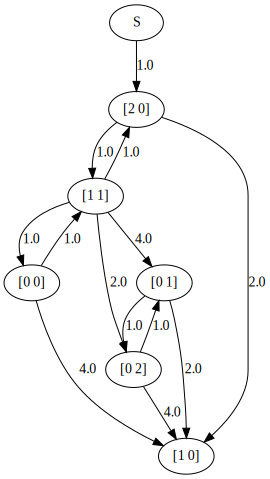

In [252]:
plot_graph(states, ipv, sim)

In [36]:
%%R
expectation(graph)

[1] 0.5038265


## Running time experiments

In [ ]:
%%R

cat("rabbits,vertices,time_to_construct,time_build_moment_graph,time_compute_expectation,time_compute_first_10_moments\n")
flush.console()
for (L in c(10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500)) {
  
  tim <- proc.time()
  state_vector_length <- 2
  graph <- create_graph(state_vector_length)
  starting_vertex <- vertex_at(graph, 1)
  initial_state <- c(L, 0)
  cat(L)
  cat(",")
  flush.console()
  add_edge(
    starting_vertex,
    create_vertex(graph, initial_state),
    1
  )
  index <- 2
  
  while (index <= vertices_length(graph)) {
    vertex <- vertex_at(graph, index)
    state <- vertex$state
    
    if (state[1] > 0) {
      # Rabbit jump left to right
      child_state <- c(state[1] - 1, state[2] + 1)
      add_edge(
        vertex,
        find_or_create_vertex(graph, child_state),
        1
      )
      
      # Island flooding
      child_state <- c(0, state[2])
      add_edge(
        vertex,
        find_or_create_vertex(graph, child_state),
        1
      )
    }
    
    if (state[2] > 0) {
      # Rabbit jump right to left
      child_state <- c(state[1] + 1, state[2] - 1)
      add_edge(
        vertex,
        find_or_create_vertex(graph, child_state),
        1
      )
      
      # Island flooding
      child_state <- c(state[1], 0)
      add_edge(
        vertex,
        find_or_create_vertex(graph, child_state),
        1
      )
    }
    
    index <- index + 1
  }
  
  cat(vertices_length(graph))
  cat(",")
  now <- proc.time()
  cat((now - tim)[3])
  cat(",")
  flush.console()
  tim <- proc.time()
  expected_waiting_time(graph)
  now <- proc.time()
  cat((now - tim)[3])
  cat(",")
  flush.console()
  
  
  tim <- proc.time()
  expected_waiting_time(graph)
  now <- proc.time()
  cat((now - tim)[3])
  cat(",")
  flush.console()
  
  tim <- proc.time()
  
  rw <-  rep(1, vertices_length(graph))
  
  for (i in 1:10) {
    rw <- expected_waiting_time(graph, rw)
  }
  now <- proc.time()
  cat((now - tim)[3])
  cat("\n")
  flush.console()
}



cat("rabbits,vertices,time_convert_matrix,time_inverse_matrix\n")
flush.console()
for (L in c(10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500)) {
  
  tim <- proc.time()
  state_vector_length <- 2
  graph <- create_graph(state_vector_length)
  starting_vertex <- vertex_at(graph, 1)
  initial_state <- c(L, 0)
  cat(L)
  cat(",")
  flush.console()
  add_edge(
    starting_vertex,
    create_vertex(graph, initial_state),
    1
  )
  index <- 2
  
  while (index <= vertices_length(graph)) {
    vertex <- vertex_at(graph, index)
    state <- vertex$state
    
    if (state[1] > 0) {
      # Rabbit jump left to right
      child_state <- c(state[1] - 1, state[2] + 1)
      add_edge(
        vertex,
        find_or_create_vertex(graph, child_state),
        1
      )
      
      # Island flooding
      child_state <- c(0, state[2])
      add_edge(
        vertex,
        find_or_create_vertex(graph, child_state),
        1
      )
    }
    
    if (state[2] > 0) {
      # Rabbit jump right to left
      child_state <- c(state[1] + 1, state[2] - 1)
      add_edge(
        vertex,
        find_or_create_vertex(graph, child_state),
        1
      )
      
      # Island flooding
      child_state <- c(state[1], 0)
      add_edge(
        vertex,
        find_or_create_vertex(graph, child_state),
        1
      )
    }
    
    index <- index + 1
  }
  
  cat(vertices_length(graph))
  cat(",")
  flush.console()
  tim <- proc.time()
  M <- graph_as_matrix(graph)
  now <- proc.time()
  cat((now - tim)[3])
  cat(",")
  flush.console()
  
  
  tim <- proc.time()
  solve(M$SIM)
  now <- proc.time()
  cat((now - tim)[3])
  cat("\n")
  flush.console()
}

rabbits,vertices,time_to_construct,time_build_moment_graph,time_compute_expectation,time_compute_first_10_moments
10,67,0.009,0.001,0,0
50,1327,0.107,0.009,0,0.003
100,5152,0.304,0.048,0.002,0.015
150,11477,0.576,0.13,0.004,0.042
200,20302,1.08,0.294,0.01,0.103
250,

## Model with two loci, two islands, and s samples

In [3]:
%%R -o states -o ipv -o sim

to_array <- function(state) {
  S <- array( state , dim = c( s+1 , s+1 , 2 ) )
  return(S)
}

setClass("conf", slots=list(locus1="numeric", locus2="numeric", population="numeric"))

obj <- new("conf", locus1=3, locus2=2, population=1)
obj@population

index_to_conf <- function(s, i) {
    #' returns the locus1, locus2, population
    #' conformation of lineages represented by
    #' state vector index i.
    stopifnot(i > 0)
    d <- s + 1 # dim
    idx <- i - 1
    p <- idx %/% d**2
    stopifnot(i <= 2*d**2)
    a <- (idx - p*d**2) %/% d
    b <- (idx - p*d**2) %% d
    return(new("conf", locus1=a, locus2=b, population=p+1))
}
conf_to_index <- function(s, a, b, p) {
    #' returns the state vector index representing
    #' the locus1, locus2, population conformation.
    d <- s + 1
    i = (p-1)*d**2 + a*d + b + 1
    return(i)
}

###########################
# sample size
s <- 5
###########################

# number of populations
p <- 2 # needs to be 2
# state vector length
n <- p*(s+1)**2

graph <- create_graph(n)
index <- 1
first_vertex <- create_vertex(graph, c(rep(0, s+2), s, rep(0, n-s-3))) # assumes that p=2
add_edge(starting_vertex(graph), first_vertex, 1)

index <- 2
while (index <= vertices_length(graph)) {
    
  vertex <- vertex_at(graph, index)
  state <- vertex$state
  
  count <- 0
  for (i in 1:n) {
      count <- count + state[i]
  }
  if (count <= 1) {
      # Only one lineage, stop
      index <- index + 1
      next
  }    
    
  for (i in 1:n) {
    conf_i <- index_to_conf(s, i)
    
    # coalescence #########################
    for (j in i:n) {
      conf_j <- index_to_conf(s, j)
      
      if (conf_i@population != conf_j@population) {
        # different populations
        next
      }
      if (i == j) {
        if (state[i] < 2) {
          next;
        }
        rate <- state[i] * (state[i] - 1) / 2
      } else {
        if (state[i] < 1 || state[j] < 1) {
          next;
        }
        rate <- state[i] * state[j]
      }
      
      child_state <- state
        
      # lineages with index i and j coalesce:  
      child_state[i] <- child_state[i] - 1
      child_state[j] <- child_state[j] - 1
      stopifnot(conf_i@locus1+conf_j@locus1 <= s)
      stopifnot(conf_i@locus2+conf_j@locus2 <= s)

      # coalescene into lineage with index k
      k = conf_to_index(s, conf_i@locus1+conf_j@locus1, conf_i@locus2+conf_j@locus2, conf_i@population)
      child_state[k] <- child_state[k] + 1
      
      child_vertex <- find_or_create_vertex(graph, child_state)
      add_edge(vertex, child_vertex, rate)
    }
    
    # recombination #######################
    if (state[i] > 0 && conf_i@locus1 > 0 && conf_i@locus2 > 0) {
      
      rate <- 3
      child_state <- state
        
      # a lineage with index i recombines to produce lineages with index k and l
      k = conf_to_index(s, conf_i@locus1, 0, conf_i@population)
      l = conf_to_index(s, 0, conf_i@locus2, conf_i@population)
      child_state[i] <- child_state[i] - 1
      child_state[k] <- child_state[k] + 1
      child_state[l] <- child_state[l] + 1
      
      child_vertex <- find_or_create_vertex(graph, child_state)
      add_edge(vertex, child_vertex, rate)
    }
    
    # migration ###########################
    if (state[i] > 0) {
      
      rate <- 0.001
      child_state <- state
        
      if (conf_i@population == 1) {
        m = 2
      } else {
        m = 1
      }
      # 
      k = conf_to_index(s, conf_i@locus1, conf_i@locus2, m)
      child_state[i] <- child_state[i] - 1
      child_state[k] <- child_state[k] + 1
      
      child_vertex <- find_or_create_vertex(graph, child_state)
      add_edge(vertex, child_vertex, rate)
    }
  }
  
  index <- index + 1
    
  if ((index %% 50) == 0) {
    cat(index, vertices_length(graph), "\n")
  }
    
}

states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state, simplify = FALSE))
ipv <- graph_as_matrix(graph)$IPV
sim <- graph_as_matrix(graph)$SIM

vertices_length(graph)

50 186 
100 336 
150 517 
200 641 
250 737 
300 862 
350 973 
400 1096 
450 1225 
500 1350 
550 1448 
600 1517 
650 1628 
700 1720 
750 1786 
800 1880 
850 1949 
900 1997 
950 2091 
1000 2161 
1050 2227 
1100 2340 
1150 2410 
1200 2500 
1250 2610 
1300 2699 
1350 2769 
1400 2845 
1450 2896 
1500 2956 
1550 3040 
1600 3114 
1650 3192 
1700 3267 
1750 3304 
1800 3344 
1850 3401 
1900 3450 
1950 3487 
2000 3517 
2050 3573 
2100 3631 
2150 3669 
2200 3703 
2250 3771 
2300 3860 
2350 3912 
2400 3953 
2450 4014 
2500 4064 
2550 4153 
2600 4213 
2650 4259 
2700 4312 
2750 4351 
2800 4406 
2850 4445 
2900 4475 
2950 4513 
3000 4582 
3050 4644 
3100 4697 
3150 4769 
3200 4825 
3250 4883 
3300 4914 
3350 4934 
3400 4967 
3450 4987 
3500 5006 
3550 5030 
3600 5062 
3650 5079 
3700 5092 
3750 5128 
3800 5184 
3850 5229 
3900 5255 
3950 5273 
4000 5308 
4050 5344 
4100 5403 
4150 5448 
4200 5483 
4250 5516 
4300 5540 
4350 5558 
4400 5594 
4450 5616 
4500 5637 
4550 5689 
4600 5745 
4650 5785 
4700

In [4]:
%%R
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

In [5]:
%%R
covariance(graph, rewards[conf_to_index(s, 1, 1, 1),], rewards[conf_to_index(s, 1, 1, 2),])

[1] 0.03712712


### Covariance for different branches at the two loci in each of the two islands



In [6]:
%%R -o cov_mat
fun <- function(a, b) mapply(function(i, j) covariance(graph, rewards[conf_to_index(s, i, j, 1),], rewards[conf_to_index(s, i, j, 2),]), a, b)
cov_mat <- outer(0:s, 0:s, fun)
cov_mat

           [,1]        [,2]         [,3]        [,4]       [,5]
[1,]  0.0000000 0.462450277 17.495772720 0.391876542 3.37002152
[2,]  0.4583130 0.037127122  0.002572802 0.004326167 0.03774363
[3,] 17.8986658 0.006029284  2.473081360 0.002565852 0.54432516
[4,]  0.3882149 0.002152109  0.001750506 0.014569070 0.04658466
[5,]  3.3679618 0.037744517  0.543144666 0.046546876 0.00000000


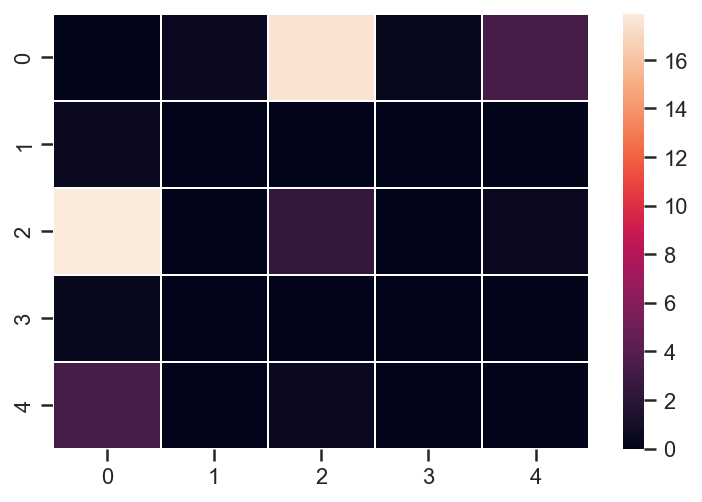

In [7]:
ax = sns.heatmap(cov_mat, 
                 linewidth=1., 
                 # xticklabels=list(range(1, cov_mat.shape[0]+1)), 
                 # yticklabels=list(range(1, cov_mat.shape[1]+1))
                )

### Covriance between tons at each locus

In [8]:
%%R -o cov_mat
locus1_rewards <- function(i) colSums(rewards[conf_to_index(s, i, 0:s, 1),]) + colSums(rewards[conf_to_index(s, i, 0:s, 2),])
locus2_rewards <- function(j) colSums(rewards[conf_to_index(s, 0:s, j, 1),]) + colSums(rewards[conf_to_index(s, 0:s, j, 2),])
fun <- function(a, b) mapply(function(i, j) covariance(graph, locus1_rewards(i), locus2_rewards(j)), a, b)
cov_mat <- outer(1:s, 1:s, fun)
cov_mat

          [,1]       [,2]      [,3]     [,4]
[1,] 30.823114  0.6529859 29.525854 76.45807
[2,]  3.369889 59.6934293  2.700777 64.38866
[3,] 29.506209  0.0202985 28.953646 75.62251
[4,] 76.697778 63.7871882 75.862449 90.69555


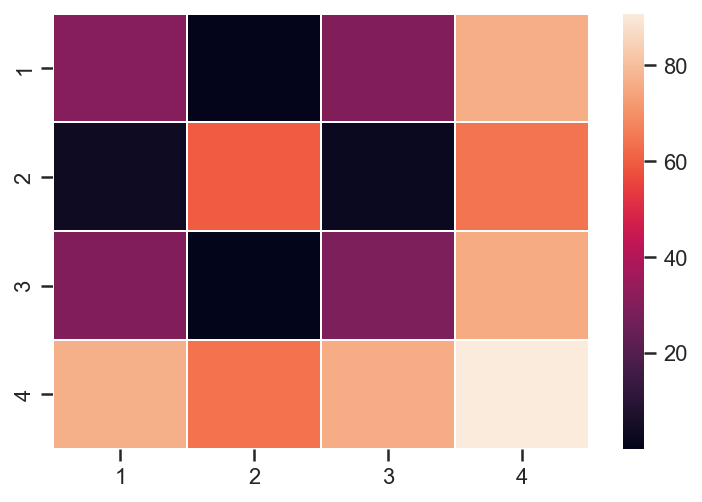

In [9]:
ax = sns.heatmap(cov_mat, 
                 linewidth=1., 
                 xticklabels=list(range(1, cov_mat.shape[0]+1)), 
                 yticklabels=list(range(1, cov_mat.shape[1]+1))
                )

In [80]:
%%R
variance(graph, rewards[conf_to_index(s, 2, 1, 2),])


[1] 0.4704917


In [65]:
%%R
expectation(graph)

[1] 4.30153


In [ ]:


plot_graph(states, ipv, sim)

In [60]:
%%R
vertices_length(graph)

[1] 269


In [65]:
%%R
expectation(graph)

[1] 4.311854
